<a href="https://colab.research.google.com/github/doggerator/ML/blob/main/Lab01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 1
## Метрические Алгоритмы

Задание 1: Применить метод K ближайших соседей (ядерный окном Парзена), взвешенный алгоритмом отбора эталонных объектов для пяти классов, сгенерированных с помощью MakeClassification

Задание 2*: для сгенерированного вами Датасета, сгенерировать профиль компактности

Задание 3: для сгенерированного вами Датасета, произвести оптимизацию по выбору ширины окна

Задание 4: найти датасет с картинками (2-3 класса) небольшой (100 картинок достаточно)

Найти метод библиотеку для построения embedding (векторизации) изображений ()
Применить этот метод для своих картинок
Применить без оптимизации kNN для полученного датасета из векторизванных картинок

Задание 5*: Сфотографируйте свои фотографии (2-3) и повторите Задание 4 с ними.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

## Задание 1
### Создаём Датасет

In [2]:
X, Y = make_classification(n_samples=250, n_features=3,
                           n_informative=3, n_classes=5,
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=50,
                                                    random_state=0)

### Запускаем Метод ближайшего соседа

In [3]:
model = KNeighborsClassifier(n_neighbors=1)
_ = model.fit(X_train, Y_train)

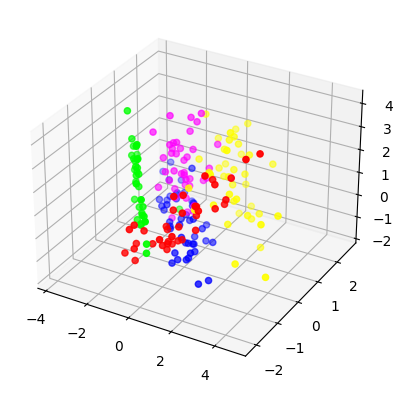

In [4]:
N = 250
colors = [np.array([1, 0, 0]).reshape(1,-1),np.array([0, 1, 0]).reshape(1,-1),np.array([0, 0, 1]).reshape(1,-1),
np.array([1, 1, 0]).reshape(1,-1),np.array([1, 0, 1]).reshape(1,-1),] # распределение цветов по классам
c = [colors[i] for i in Y_train[:N]] # распределение цветов по классам
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:N,0], X_train[:N,1], X_train[:N,2], c=c) # изображаем классификацию
plt.show()

### Запускаем Ядерное взвешивание Окном Парзена

In [5]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

model1 = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h)) # обучение с коэфициентом 0.05
model1.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=200,
                     weights=<function <lambda> at 0x7b84a0e0cb80>)

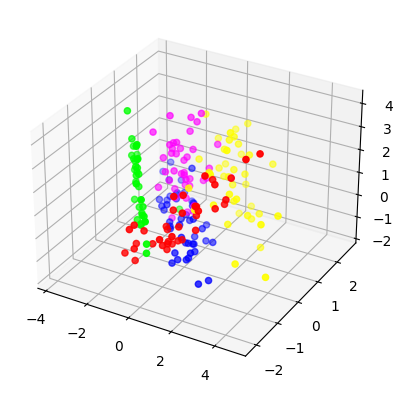

In [6]:
N = 250
colors = [np.array([1, 0, 0]).reshape(1,-1),np.array([0, 1, 0]).reshape(1,-1),np.array([0, 0, 1]).reshape(1,-1),
np.array([1, 1, 0]).reshape(1,-1),np.array([1, 0, 1]).reshape(1,-1),] # распределение цветов по классам
c = [colors[i] for i in Y_train[:N]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:N,0], X_train[:N,1], X_train[:N,2], c=c)

#for i, h in enumerate([0.05, 0.1, 0.2, 0.5]):
#    model = KNeighborsClassifier(n_neighbors=len(X_train),
#                                 weights=lambda x: K(x, h=h))
#    model.fit(X_train, Y_train)
#    ax.append(fig.add_subplot(gs[i]))
#    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

In [7]:
model2 = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=0.5)) # обучение с коэфициентом 0.5
model2.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=200,
                     weights=<function <lambda> at 0x7b85760c92d0>)

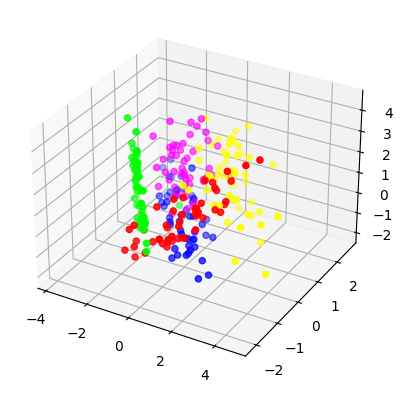

In [8]:
N = 250
colors = [np.array([1, 0, 0]).reshape(1,-1),np.array([0, 1, 0]).reshape(1,-1),np.array([0, 0, 1]).reshape(1,-1),
np.array([1, 1, 0]).reshape(1,-1),np.array([1, 0, 1]).reshape(1,-1),] # распределение цветов по классам
c = [colors[i] for i in Y[:N]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=c)

#for i, h in enumerate([0.05, 0.1, 0.2, 0.5]):
#    model = KNeighborsClassifier(n_neighbors=len(X_train),
#                                 weights=lambda x: K(x, h=h))
#    model.fit(X_train, Y_train)
#    ax.append(fig.add_subplot(gs[i]))
#    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

### Запускаем Алгоритм отбора эталонных объектов

Понятие отступа для метрического классификатора:
$$
M\bigr(x_i\bigr) = \Gamma_{y_i}\bigr(x_i\bigr) - \max_{y\in Y\setminus{y_i}}\Gamma_{y}\bigr(x_i\bigr),
$$
другими словами, отступ показывает насколько истинный класс далеко от другого класса. В случае, если отступ положительный, то предсказание является верным. В случае, если отступ отрицательный, то предсказание является ошибочным.

Но для начала нужно сделать несколько шагов:

1) Для каждого элемента выборки найти сумму евклидового расстояния до ближайших n соседей;

2) Отсортировать элементы выборки по сумме расстояний;

3) Взять первые N элементов - они и будут эталонными объектами.

In [9]:
def scores(self, X):
        features = self.gams*self.kernel(cdist(X, self.X))
        #print(self.kernel(cdist(X, self.X)))
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1),
             np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1)]).T
        return scores

In [10]:
neighbours_0, neighbours_1, neighbours_2, neighbours_3, neighbours_4 = [], [], [], [], []
# Разделим элементы по классам
for i in range(200):
    if Y_train[i] == 0:
        neighbours_0 = np.append(neighbours_0, X_train[i])
    elif Y_train[i] == 1:
        neighbours_1 = np.append(neighbours_1, X_train[i])
    elif Y_train[i] == 2:
        neighbours_2 = np.append(neighbours_2, X_train[i])
    elif Y_train[i] == 3:
        neighbours_3 = np.append(neighbours_3, X_train[i])
    else:
        neighbours_4 = np.append(neighbours_4, X_train[i])


neighbours_0 = np.reshape(neighbours_0, (-1,3))
neighbours_1 = np.reshape(neighbours_1, (-1,3))
neighbours_2 = np.reshape(neighbours_2, (-1,3))
neighbours_3 = np.reshape(neighbours_3, (-1,3))
neighbours_4 = np.reshape(neighbours_4, (-1,3))

In [11]:
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(neighbours_0)

#for i in range(len(neighbours_0)):
#    print(neigh.kneighbors([X_train[i]]))

ed_sums_0 = np.zeros(len(neighbours_0))
for i in range(len(neighbours_0)):
    ed_sums_0[i] = np.sum(neigh.kneighbors([neighbours_0[i]])[0]) # суммы евклидовых расстояний
print("Sums of distances [CLASS 0]: \n", ed_sums_0)
np.sort(ed_sums_0) # Сортируем по минимуму
print("SORTED Sums of distances [CLASS 0]: \n",ed_sums_0)
eds_indices_0 = np.argsort(ed_sums_0) # Индексы отсортированного массива
print("INDICES OF SORTED Sums of distances [CLASS 0]: \n", eds_indices_0)

Sums of distances [CLASS 0]: 
 [ 8.07247138  6.7158566   7.08195233 10.19346401  5.24872053  8.23634176
  8.50122467  9.47195821 10.36471954  9.19283838  5.09638817  4.39897295
 16.99676992  9.21069843  5.27127774  8.68978943  9.17155087  5.85857199
  3.37522599  4.22374542  7.94919731  6.46891779  9.37502719  6.15692665
  8.92049193  6.49958785 19.48832024  4.20425934  3.47989473  6.65569447
  7.19324299  5.39323075  8.2538363   7.33984604  7.71369377  7.43894117
  6.11464654  7.51716715]
SORTED Sums of distances [CLASS 0]: 
 [ 8.07247138  6.7158566   7.08195233 10.19346401  5.24872053  8.23634176
  8.50122467  9.47195821 10.36471954  9.19283838  5.09638817  4.39897295
 16.99676992  9.21069843  5.27127774  8.68978943  9.17155087  5.85857199
  3.37522599  4.22374542  7.94919731  6.46891779  9.37502719  6.15692665
  8.92049193  6.49958785 19.48832024  4.20425934  3.47989473  6.65569447
  7.19324299  5.39323075  8.2538363   7.33984604  7.71369377  7.43894117
  6.11464654  7.51716715]
IND

In [12]:
neigh.fit(neighbours_1)

#for i in range(len(neighbours_1)):
#    print(neigh.kneighbors([X_train[i]]))

ed_sums_1 = np.zeros(len(neighbours_1))
for i in range(len(neighbours_1)):
    ed_sums_1[i] = np.sum(neigh.kneighbors([neighbours_1[i]])[0]) # суммы евклидовых расстояний
print("Sums of distances [CLASS 1]: \n", ed_sums_1)
np.sort(ed_sums_1) # Сортируем по минимуму
print("SORTED Sums of distances [CLASS 1]: \n",ed_sums_1)
eds_indices_1 = np.argsort(ed_sums_1) # Индексы отсортированного массива
print("INDICES OF SORTED Sums of distances [CLASS 1]: \n", eds_indices_1)

Sums of distances [CLASS 1]: 
 [ 8.24497593 16.91376276 12.59104708  9.77380015  6.61891429  9.44348329
  6.14683299  9.8557578   6.47629612  6.74387157 12.74476864 11.33389823
  9.29720687  8.49222893  7.19936866  7.08037102  8.41933331  7.96628638
  9.04691281  9.90165973 13.76423423 21.71155179 13.20089401  7.55499391
  8.19043634 13.95823967 13.61721625  6.86771523  7.84649905 10.92352804
  5.77083665 10.42787177  8.48094123  5.99678574]
SORTED Sums of distances [CLASS 1]: 
 [ 8.24497593 16.91376276 12.59104708  9.77380015  6.61891429  9.44348329
  6.14683299  9.8557578   6.47629612  6.74387157 12.74476864 11.33389823
  9.29720687  8.49222893  7.19936866  7.08037102  8.41933331  7.96628638
  9.04691281  9.90165973 13.76423423 21.71155179 13.20089401  7.55499391
  8.19043634 13.95823967 13.61721625  6.86771523  7.84649905 10.92352804
  5.77083665 10.42787177  8.48094123  5.99678574]
INDICES OF SORTED Sums of distances [CLASS 1]: 
 [30 33  6  8  4  9 27 15 14 23 28 17 24  0 16 32 13 

In [13]:
neigh.fit(neighbours_2)

#for i in range(len(neighbours_2)):
#    print(neigh.kneighbors([X_train[i]]))

ed_sums_2 = np.zeros(len(neighbours_2))
for i in range(len(neighbours_2)):
    ed_sums_2[i] = np.sum(neigh.kneighbors([neighbours_2[i]])[0]) # суммы евклидовых расстояний
print("Sums of distances [CLASS 2]: \n", ed_sums_2)
np.sort(ed_sums_2) # Сортируем по минимуму
print("SORTED Sums of distances [CLASS 2]: \n",ed_sums_2)
eds_indices_2 = np.argsort(ed_sums_2) # Индексы отсортированного массива
print("INDICES OF SORTED Sums of distances [CLASS 2]: \n", eds_indices_2)

Sums of distances [CLASS 2]: 
 [ 5.84455242  6.30364122  4.96983311  9.20402226  5.69473877  5.6279219
  6.76166799  5.66028286 15.60706714  4.7393566   5.9935317   6.73779279
  5.40895806  5.82012086  6.23870782  5.21517621  7.16813545  6.01117828
  4.80242583  5.1854851   5.14395837  5.43617876  6.14667517  6.10277311
  7.69698565 11.80818877  7.7766713   5.88937622  5.00015263  7.25804182
  4.77418439 11.22816773  4.70687125  6.21264174  5.68702167  6.98735775
  6.79809999 12.87243615  5.13767574 14.2162638   6.07467697  7.6219536
  5.70646878 10.21379586 12.33824991  7.77897573]
SORTED Sums of distances [CLASS 2]: 
 [ 5.84455242  6.30364122  4.96983311  9.20402226  5.69473877  5.6279219
  6.76166799  5.66028286 15.60706714  4.7393566   5.9935317   6.73779279
  5.40895806  5.82012086  6.23870782  5.21517621  7.16813545  6.01117828
  4.80242583  5.1854851   5.14395837  5.43617876  6.14667517  6.10277311
  7.69698565 11.80818877  7.7766713   5.88937622  5.00015263  7.25804182
  4.7741

In [14]:
neigh.fit(neighbours_3)

#for i in range(len(neighbours_3)):
#    print(neigh.kneighbors([X_train[i]]))

ed_sums_3 = np.zeros(len(neighbours_3))
for i in range(len(neighbours_3)):
    ed_sums_3[i] = np.sum(neigh.kneighbors([neighbours_3[i]])[0]) # суммы евклидовых расстояний
print("Sums of distances [CLASS 3]: \n", ed_sums_3)
np.sort(ed_sums_3) # Сортируем по минимуму
print("SORTED Sums of distances [CLASS 3]: \n",ed_sums_3)
eds_indices_3 = np.argsort(ed_sums_3) # Индексы отсортированного массива
print("INDICES OF SORTED Sums of distances [CLASS 3]: \n", eds_indices_3)

Sums of distances [CLASS 3]: 
 [ 9.02246029 10.08380346  9.97999149 13.34276356 12.168744    9.86095954
 10.89095841  8.86101796  8.02332604 12.15425884 11.72989572 24.1971393
 18.61149633 16.98687319 12.51646585 12.33671705  8.94524593  9.96371952
 11.16296456 12.56575055 16.07674717  9.8600749   9.22272787  8.77854772
 10.28606835 14.23986204 13.38181741 15.33695974  8.95384123  9.58806482
  9.59917849  8.20066035 16.7728807   9.31979446  8.50312539 10.94535409
 17.86876972  9.4082892  11.50399714 11.04277807 17.69316975]
SORTED Sums of distances [CLASS 3]: 
 [ 9.02246029 10.08380346  9.97999149 13.34276356 12.168744    9.86095954
 10.89095841  8.86101796  8.02332604 12.15425884 11.72989572 24.1971393
 18.61149633 16.98687319 12.51646585 12.33671705  8.94524593  9.96371952
 11.16296456 12.56575055 16.07674717  9.8600749   9.22272787  8.77854772
 10.28606835 14.23986204 13.38181741 15.33695974  8.95384123  9.58806482
  9.59917849  8.20066035 16.7728807   9.31979446  8.50312539 10.9453

In [15]:
neigh.fit(neighbours_4)

#for i in range(len(neighbours_4)):
#    print(neigh.kneighbors([X_train[i]]))

ed_sums_4 = np.zeros(len(neighbours_4))
for i in range(len(neighbours_4)):
    ed_sums_4[i] = np.sum(neigh.kneighbors([neighbours_4[i]])[0]) # суммы евклидовых расстояний
print("Sums of distances [CLASS 4]: \n", ed_sums_4)
np.sort(ed_sums_4) # Сортируем по минимуму
print("SORTED Sums of distances [CLASS 4]: \n",ed_sums_4)
eds_indices_4 = np.argsort(ed_sums_4) # Индексы отсортированного массива
print("INDICES OF SORTED Sums of distances [CLASS 4]: \n", eds_indices_4)

Sums of distances [CLASS 4]: 
 [ 5.21130119  4.91959116  5.5841144   6.36218606 10.4802663  10.64201524
 11.81109068  3.86385253  7.2936506   4.12723071  3.98574472  6.9143348
  7.72465158  4.65297938 10.12181103  5.81584302  3.79516407  4.28639713
  6.62434443  4.86118632  5.81280014  6.73257278  8.53547555  4.01043644
  7.26866668  5.1386153   4.30933584  9.97229434  4.59464507  3.65872974
  7.04171041  8.33359507  4.89954722  4.17622107  6.03857075  5.36599313
  5.51070394  4.22709768  4.1334929  12.45024491  4.5411195 ]
SORTED Sums of distances [CLASS 4]: 
 [ 5.21130119  4.91959116  5.5841144   6.36218606 10.4802663  10.64201524
 11.81109068  3.86385253  7.2936506   4.12723071  3.98574472  6.9143348
  7.72465158  4.65297938 10.12181103  5.81584302  3.79516407  4.28639713
  6.62434443  4.86118632  5.81280014  6.73257278  8.53547555  4.01043644
  7.26866668  5.1386153   4.30933584  9.97229434  4.59464507  3.65872974
  7.04171041  8.33359507  4.89954722  4.17622107  6.03857075  5.3659

In [17]:
REFS = []
REFS_DIST = []

for i in range(5):
    REFS = np.append(REFS, neighbours_0[eds_indices_0[i]])
for i in range(5):
    REFS = np.append(REFS, neighbours_1[eds_indices_1[i]])
for i in range(5):
    REFS = np.append(REFS, neighbours_2[eds_indices_2[i]])
for i in range(5):
    REFS = np.append(REFS, neighbours_3[eds_indices_3[i]])
for i in range(5):
    REFS = np.append(REFS, neighbours_4[eds_indices_4[i]])

REFS = np.reshape(REFS, (-1, 3))

for i in range(5):
    REFS_DIST = np.append(REFS_DIST, ed_sums_0[i])
    REFS_DIST = np.append(REFS_DIST, ed_sums_1[i])
    REFS_DIST = np.append(REFS_DIST, ed_sums_2[i])
    REFS_DIST = np.append(REFS_DIST, ed_sums_3[i])
    REFS_DIST = np.append(REFS_DIST, ed_sums_4[i])

REFS_DIST = np.reshape(REFS, (-1, 5))

Y_REFS = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]

REFS, REFS_DIST, Y_REFS

(array([[ 0.34104811, -1.03501071, -0.04904284],
        [ 0.31436681, -1.04445448, -0.14134127],
        [ 0.3667774 , -0.88916284, -0.2708139 ],
        [ 0.407828  , -1.15861701, -0.26812702],
        [ 0.62991956, -0.8736424 , -0.07270525],
        [-1.76476056, -0.41907262,  2.07905311],
        [-1.79329292, -0.44629976,  1.76479676],
        [-2.21672763, -0.16661934,  2.15814555],
        [-2.46678396,  0.11521792,  1.76891622],
        [-2.1253207 , -0.112863  ,  1.57170561],
        [ 0.43272205, -0.01292869, -1.01478397],
        [ 0.07976373,  0.11338521, -1.19395229],
        [ 0.28869086, -0.57118702, -1.26998034],
        [ 0.5959982 , -0.37017223, -1.2895821 ],
        [ 0.60240628, -0.08159885, -1.25108568],
        [ 1.11534395,  1.2461787 ,  1.41813996],
        [ 1.02839399,  1.07324668,  1.219697  ],
        [ 1.38254945,  1.51717233,  1.07295778],
        [ 1.63675019,  0.72984236,  0.59036134],
        [ 0.24367164,  1.64657081,  0.57475796],
        [-1.40464086

In [18]:
# Отделим вершины от эталонных
NOT_REFS = X
NOT_REFS = np.delete(NOT_REFS, np.where(np.in1d(X, REFS)))
NOT_REFS = np.reshape(NOT_REFS, (-1, 3))
print(len(NOT_REFS))

225


In [19]:
Y_NOT_REFS = Y
Y_NOT_REFS = np.delete(Y_NOT_REFS, np.where(np.in1d(X[:,0], REFS[:,0])))
print(len(Y_NOT_REFS))

225


In [20]:
def K(distance, h=0.2):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

In [21]:
model = KNeighborsClassifier(n_neighbors=len(REFS),
                                 weights=lambda x: K(x, h=h))
model.fit(REFS, Y_REFS)

KNeighborsClassifier(n_neighbors=25,
                     weights=<function <lambda> at 0x7b849f4f5090>)

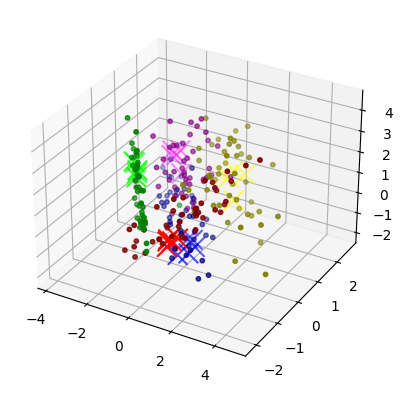

In [22]:
N = 250
colors = [np.array([1, 0, 0]).reshape(1,-1),np.array([0, 1, 0]).reshape(1,-1),np.array([0, 0, 1]).reshape(1,-1),
np.array([1, 1, 0]).reshape(1,-1),np.array([1, 0, 1]).reshape(1,-1),] # распределение цветов по классам
c = [colors[i]/2 for i in Y_NOT_REFS[:N]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(NOT_REFS[:,0], NOT_REFS[:,1], NOT_REFS[:,2], c=c, s=10)
c = [colors[i] for i in Y_REFS[:N]]
ax.scatter(REFS[:,0], REFS[:,1], REFS[:,2], c=c, s=200, marker='x')

## Задание 2*
### Вычислим Профиль компактности
[Профиль компкатности](http://www.machinelearning.ru/wiki/index.php?title=Профиль_компактности) - функция доли объектов $x_i$, у которых $m$-й сосед $x_{i}^{(m)}$  лежит в другом классе ($m$ - номер соседей, $X^{l}$ - выборка):

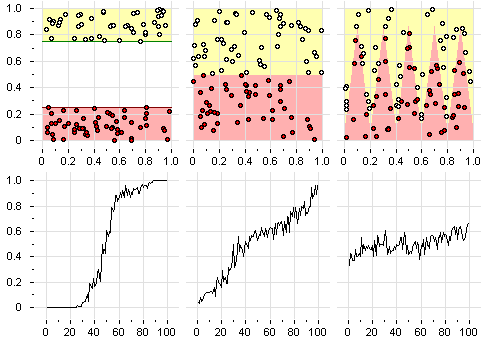

Профиль компактности является формальным выражением гипотезы компактности — предположения о том, что схожие объекты гораздо чаще лежат в одном классе, чем в разных. Чем проще задача, то есть чем чаще близкие объекты оказываются в одном классе, тем сильнее «прижимается к нулю» начальный участок профиля. В сложных задачах или при неудачном выборе функции расстояния ближайшие объекты практически не несут информации о классах, и профиль вырождается в константу, близкую к 0.5.

In [23]:
def compactness_profile(index:int, X, y, metric='euclidean'):
    """
    http://www.machinelearning.ru/wiki/index.php?title=Профиль_компактности
    param index: индекс
    param X: матрица объект-признак, для которой хотим посчитать профиль компактности
    param y: вектор таргетов для этих объектов
    param metric: ['euclidean', 'cosine', ...]
    """
    assert 0<=index <= X.shape[0]
    neigh = NearestNeighbors(n_neighbors=X.shape[0], metric=metric)
    neigh.fit(X, y)
    distances, indexes = neigh.kneighbors(X)
    return (y != y[indexes[:, index]]).mean() #вычисление Профиля компактности
RVec = np.vectorize(compactness_profile)

In [24]:
# визуалицация
t1 = np.array(list(range(1,X_train.shape[0])))
T1 = np.array(
    [compactness_profile(i,X_train,Y_train) for i in t1]
    )
import plotly.express as px
fig = px.line(x=t1, y=T1)
fig.show()

## Задание 3
### Проведём оптимизацию по ширине окна

Ширину окна можно назвать Гиперпараметром — характеристикой модели, которая фиксируется до начала обучения.
Гиперпараметры, в отличие от параметров задаются разработчиком модели перед ее обучением, в свою очередь параметры модели настраиваются в процессе обучения модели на данных.

А как мы знаем из Лабораторной работы №4 предыдущего семестра, Optuna — это фреймворк для для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения. Она подбирает эти параметры методом проб и ошибок.

In [28]:
!pip install --quiet optuna
import optuna

def objective(trial):
    h_opt = trial.suggest_float("h_opt", 0.01, 100, log=True)
    model3 = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=h_opt)) # обучение с коэфициентом h
    model3.fit(X_train, Y_train)
    return 1 / model3.score(X_test, Y_test, sample_weight=None)

optuna.logging.disable_default_handler() #Отключить логирование
study = optuna.create_study()
study.optimize(objective, n_trials=400)

best_params = study.best_params
found_h_opt = best_params["h_opt"]
model3 = KNeighborsClassifier(n_neighbors=len(X_train),
                                 weights=lambda x: K(x, h=found_h_opt)) # обучение с коэфициентом h
model3.fit(X_train, Y_train)
print("Найденная ширина окна h: {:0.3f}, Точность при данной ширине окна: {:0.3f}".format(found_h_opt, model3.score(X_test, Y_test, sample_weight=None)))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00
Найденная ширина окна h: 0.977, Точность при данной ширине окна: 0.860
